In [3]:


import os
import pandas as pd

# Configuration
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr, kendalltau
from statsmodels.stats.inter_rater import fleiss_kappa
import nltk
from nltk.translate.bleu_score import sentence_bleu
from sentence_transformers import SentenceTransformer
import json
from collections import Counter
from pingouin import intraclass_corr as icc
from sklearn.metrics.pairwise import cosine_similarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_auc_score, cohen_kappa_score,
    mean_absolute_error, mean_squared_error,
    accuracy_score, precision_score, recall_score, 
    f1_score, matthews_corrcoef
)
from typing import List, Dict, Union
model = SentenceTransformer("all-MiniLM-L6-v2")
nltk.download('punkt')
sentiment_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NOBZ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:

#Lodad Data

llms = ['anthropic', 'chatgpt', 'deepseek', 'gemini', 'llama']
output_folder = 'crew_agents\\result'
no_of_essay_categories = 6
human_graded_folder = 'crew_agents\\prompts\\guidelines'

# Define categories
headers1 = ['EssayID', 'PromptID', 'Content', 'Organization', 'WordChoice', 'SentenceFluency', 'Conventions', 'Feedback']
headers2 = ['EssayID', 'PromptID', 'Content', 'PromptAdherence', 'Language', 'Narrativity', 'Feedback']
headers3 = headers2
grading_category1= ['Content', 'Organization', 'WordChoice','SentenceFluency', 'Conventions']
grading_category2 = ['Content', 'Language','PromptAdherence', 'Narrativity']
grading_category3 = grading_category2

# Rubric maxima
rubric_maxima1 = {
    'Content': 6,
    'Organization': 6,
    'WordChoice': 6,
    'SentenceFluency': 6,
    'Conventions': 6

}

# Rubric maxima
rubric_maxima2 = {
    'Content': 3,
    'Language': 3,
    'PromptAdherence': 3,
    'Narrativity': 3,
}

# Rubric maxima
rubric_maxima3 = {
    'Content': 4,
    'Language': 4,
    'PromptAdherence': 4,
    'Narrativity': 4,
}


# Expected grade range
expected_grade_range1 = (0, 6)
# Expected grade range
expected_grade_range2 = (0, 3)
# Expected grade range
expected_grade_range3 = (0, 4)
# Initialize DataFrames
results1 = pd.DataFrame(columns=headers1)
results2 = pd.DataFrame(columns=headers2)
results3 = pd.DataFrame(columns=headers3)

human_graded_scores1 = pd.DataFrame()
human_graded_scores2 = pd.DataFrame()
# Evaluate llm performance
threshold = 1
no_of_submissions  = 11
no_of_agents = 3
no_of_graded_work = no_of_submissions * no_of_agents  * 2

def calculate_avg_time_per_submission(file_path):
    total_time = 0.0
    total_submissions = 0
    
    try:
        with open(file_path, 'r') as file:
            current_entry = {}
            
            for line in file:
                line = line.strip()
                if not line:
                    continue
                    
                if line.startswith("Number of submissions:"):
                    try:
                        if current_entry and "Execution time" in current_entry and "Number of submissions" in current_entry:
                            total_time += current_entry["Execution time"]
                            total_submissions += current_entry["Number of submissions"]
                        
                        current_entry = {
                            "Number of submissions": int(line.split(":")[1].strip())
                        }
                    except (ValueError, IndexError):
                        print(f"Error parsing 'Number of submissions' in line: {line}")
                        continue
                elif line.startswith("Execution time:"):
                    try:
                        current_entry["Execution time"] = float(line.split(":")[1].strip().split()[0])
                    except (ValueError, IndexError):
                        print(f"Error parsing 'Execution time' in line: {line}")
                        continue
            
            # Process the last entry
            if current_entry and "Execution time" in current_entry and "Number of submissions" in current_entry:
                total_time += current_entry["Execution time"]
                total_submissions += current_entry["Number of submissions"]
        
        return total_time / total_submissions if total_submissions > 0 else 0.0
    except FileNotFoundError:
        print(f"Time log file not found: {file_path}")
        return 0.0

# Load human graded data once
for x in range(1, no_of_essay_categories + 1):
    folder = os.path.join(human_graded_folder, f'prompt{x}')
    file = os.path.join(folder, f'Prompt-{x}.csv')
    try:
        
        # Rename columns consistently
        if x <= 2:
            df1 = pd.read_csv(file, encoding='utf-8-sig')  # Handles BOM
            df1 = df1.rename(columns={
                "Word Choice": "WordChoice",
                "Sentence Fluency": "SentenceFluency"
            })
        else:
            df2 = pd.read_csv(file, encoding='utf-8-sig')  # Handles BOM
            df2 = df2.rename(columns={
                "Prompt Adherence": "PromptAdherence"
            })
        # Store in appropriate human scores DataFrame
        if x <= 2:
            human_graded_scores1 = pd.concat([human_graded_scores1, df1], ignore_index=True)
        else:
            human_graded_scores2 = pd.concat([human_graded_scores2, df2], ignore_index=True)
    except Exception as e:
        print(f"Error loading human grades for prompt {x}: {str(e)}")

human_graded_scores3 = human_graded_scores2
# Process LLM results
for llm in llms:
    result_folder = os.path.join(output_folder, llm)
    for x in range(1, no_of_essay_categories + 1):
        category_folder = os.path.join(result_folder, f'prompt{x}')
        ai_grade_file = os.path.join(category_folder, 'grades.csv')
        timeLog_file = os.path.join(category_folder, f'timeLog.txt_{x}')
        
        try:
            print(x)
            result_df = pd.read_csv(ai_grade_file, encoding="utf-8", encoding_errors="ignore")   
                  
            result_df['LLM'] = llm
            result_df['PromptID'] = x
            result_df['ExecutionTime'] = calculate_avg_time_per_submission(timeLog_file)
            
            # Clean column names
            result_df.columns = [col.replace('ï»¿', '') for col in result_df.columns]
            
            # Add to appropriate results DataFrame
            if x <= 2:
                results1 = pd.concat([results1, result_df], ignore_index=True)
            elif x > 2 and x < 5:
                results2 = pd.concat([results2, result_df], ignore_index=True)
            elif x >= 5:
                results3 = pd.concat([results3, result_df], ignore_index=True)
                print(len(results3))
                
        except Exception as e:
            print(f"Error processing {llm} prompt {x}: {str(e)}")

# Final cleanup
results1.columns = [col.replace('ï»¿', '') for col in results1.columns]
results2.columns = [col.replace('ï»¿', '') for col in results2.columns]
results3.columns = [col.replace('ï»¿', '') for col in results3.columns]

Error loading human grades for prompt 1: [Errno 2] No such file or directory: 'crew_agents\\prompts\\guidelines\\prompt1\\Prompt-1.csv'
Error loading human grades for prompt 2: [Errno 2] No such file or directory: 'crew_agents\\prompts\\guidelines\\prompt2\\Prompt-2.csv'
Error loading human grades for prompt 3: [Errno 2] No such file or directory: 'crew_agents\\prompts\\guidelines\\prompt3\\Prompt-3.csv'
Error loading human grades for prompt 4: [Errno 2] No such file or directory: 'crew_agents\\prompts\\guidelines\\prompt4\\Prompt-4.csv'
Error loading human grades for prompt 5: [Errno 2] No such file or directory: 'crew_agents\\prompts\\guidelines\\prompt5\\Prompt-5.csv'
Error loading human grades for prompt 6: [Errno 2] No such file or directory: 'crew_agents\\prompts\\guidelines\\prompt6\\Prompt-6.csv'
1
Error processing anthropic prompt 1: [Errno 2] No such file or directory: 'crew_agents\\result\\anthropic\\prompt1\\grades.csv'
2
Error processing anthropic prompt 2: [Errno 2] No su

In [5]:



def calculate_consistency(data, categories):
    """
    Calculates the consistency of LLM scoring using standard deviation and ICC.

    Args:
        data: A list of dictionaries, where each dictionary represents an essay
              grading instance with 'EssayID', 'LLM', and score keys
              (e.g., 'Adherence', 'Language', 'Narrativity').

    Returns:
        A dictionary where keys are LLM names and values are dictionaries
        containing 'average_std_dev' and 'icc' (if applicable).
    """
    llm_scores = {}
    for item in data:
        llm = item['LLM']
        essay_id = item['EssayID']
        for score_type in categories:
            if score_type in item:
                if llm not in llm_scores:
                    llm_scores[llm] = {}
                if essay_id not in llm_scores[llm]:
                    llm_scores[llm][essay_id] = {}
                if score_type not in llm_scores[llm][essay_id]:
                    llm_scores[llm][essay_id][score_type] = []
                llm_scores[llm][essay_id][score_type].append(item[score_type])

    consistency_results = {}
    for llm, essay_data in llm_scores.items():
        std_devs = {}
        rater_matrices = {}
        for essay_id, scores in essay_data.items():
            for score_type, values in scores.items():
                if len(values) > 1:
                    if score_type not in std_devs:
                        std_devs[score_type] = []
                    std_devs[score_type].append(np.std(values))
                    if score_type not in rater_matrices:
                        rater_matrices[score_type] = []
                    rater_matrices[score_type].append(values)

        consistency_results[llm] = {}
        for score_type, std_list in std_devs.items():
            consistency_results[llm][f'average_std_dev_{score_type}'] = np.mean(std_list) if std_list else None
            if score_type in rater_matrices and len(rater_matrices[score_type]) > 1 and all(len(row) > 1 for row in rater_matrices[score_type]):
                    # Prepare the data for ICC calculation
                    icc_data = []
                    for essay_idx, values in enumerate(rater_matrices[score_type]):
                        for rater_idx, score in enumerate(values):
                            icc_data.append({'EssayID': essay_idx, 'LLM': rater_idx, 'score': score})
                    icc_df = pd.DataFrame(icc_data)
                    # Calculate ICC(3,1) - absolute agreement, single rater measurement
                    icc_result = icc(icc_df, targets='EssayID', raters='LLM', ratings='score', nan_policy='omit')
                    consistency_results[llm][f'icc_{score_type}'] = icc_result['ICC'][2]  # ICC(3,1)
            else:
                consistency_results[llm][f'icc_{score_type}'] = "Insufficient data for ICC calculation"

    return consistency_results

def calculate_accuracy(llm_data, human_grades, categories):
    """
    Calculates the accuracy of LLM scoring compared to human grades.

    Args:
        llm_data: A list of dictionaries, where each dictionary represents an essay
                  grading instance with 'EssayID', 'LLM', and score keys.
        human_grades: A dictionary where keys are 'EssayID' and values are
                      dictionaries containing human-assigned scores for
                      'Adherence', 'Language', 'PromptAdherence', 'Narrativity'.

    Returns:
        A dictionary where keys are LLM names and values are dictionaries
        containing MAE, RMSE, and Pearson correlation for each score type.
    """
    #contains the mean score of the three agents for each grading category for each submission
    llm_aggregated_scores = {}
    #for each graded submission
    for item in llm_data:
        #get the llm that graded
        llm = item['LLM']
        # get the submission id which same as essayid
        essay_id = item['EssayID']
        if llm not in llm_aggregated_scores:
            #new list for each llm
            llm_aggregated_scores[llm] = {}
        if essay_id not in llm_aggregated_scores[llm]:
            #Each essay is graded at least 3 times by each llm, get each scores assigned to the same essay
            llm_aggregated_scores[llm][essay_id] = {}
        # for each category graded in in same essay
        for score_type in categories:
            if score_type in item:
                if score_type not in llm_aggregated_scores[llm][essay_id]:
                    llm_aggregated_scores[llm][essay_id][score_type] = []
                #append the score to the list of scores by each grader agent
                llm_aggregated_scores[llm][essay_id][score_type].append(item[score_type])
    #{llm:{essayid:{content:[1,2,3]}}}
    #aggregated list has one row per submission(essayid) for each llm instead of multiple
    accuracy_results = {}
    #for each graded submission by llm
    for llm, essay_scores in llm_aggregated_scores.items():
        accuracy_results[llm] = {}
        #get the categories
        for score_type in categories:
            llm_scores_list = []
            human_scores_list = []
            #iterate through the submissions
            for essay_id, scores in essay_scores.items():
                if score_type in scores:
                    # get the mean score for each category from the llm scores
                    llm_scores_list.append(np.mean(scores[score_type]))
                    # get the human score
                    human_score = next((item for item in human_grades if item.get('EssayID') == essay_id), None)
                    if not human_score:
                        print(essay_id)
                    score = human_score[score_type]
                    human_scores_list.append(score)
            #// 11 ROWS
            if llm_scores_list and human_scores_list:
                accuracy_results[llm][f'mae_{score_type}'] = mean_absolute_error(human_scores_list, llm_scores_list)
                accuracy_results[llm][f'rmse_{score_type}'] = np.sqrt(mean_squared_error(human_scores_list, llm_scores_list))
                corr, _ = pearsonr(human_scores_list, llm_scores_list)
                accuracy_results[llm][f'pearson_r_{score_type}'] = corr
            else:
                accuracy_results[llm][f'mae_{score_type}'] = "Insufficient matching data"
                accuracy_results[llm][f'rmse_{score_type}'] = "Insufficient matching data"
                accuracy_results[llm][f'pearson_r_{score_type}'] = "Insufficient matching data"

    return accuracy_results

def calculate_task_completion_rate(data, total_expected_essays):
    """
    Calculates the task completion rate (assuming each item is one completion attempt).

    Args:
        data: A list of dictionaries, where each dictionary represents an essay
              grading instance.
        total_expected_essays: The total number of essays that were supposed to be graded.

    Returns:
        A dictionary where keys are LLM names and values are the task completion rate (percentage).
    """
    llm_completion_counts = Counter(item['LLM'] for item in data)
    completion_rates = {}
    for llm, count in llm_completion_counts.items():
        completion_rates[llm] = (count / total_expected_essays) * 100 if total_expected_essays > 0 else 0
    return completion_rates

def calculate_execution_time(data):
    """
    Calculates the average execution time for each LLM.

    Args:
        data: A list of dictionaries, where each dictionary represents an essay
              grading instance with 'LLM' and 'ExecutionTime'.

    Returns:
        A dictionary where keys are LLM names and values are the average execution time in seconds.
    """
    llm_times = {}
    llm_counts = {}
    for item in data:
        llm = item['LLM']
        execution_time = item.get('ExecutionTime')
        if execution_time is not None:
            if llm not in llm_times:
                llm_times[llm] = 0
                llm_counts[llm] = 0
            llm_times[llm] += execution_time
            llm_counts[llm] += 1

    average_times = {}
    for llm, total_time in llm_times.items():
        average_times[llm] = total_time / llm_counts[llm] if llm_counts[llm] > 0 else 0
    return average_times

def evaluate_llm_grading_performance(
    llm_data: List[Dict],
    human_grades: List[Dict],
    categories: List[str],
    threshold: Union[float, Dict[str, float]]
) -> Dict[str, Dict[str, Dict]]:
    """
    Evaluates LLM grading performance across multiple categories as binary classification tasks.
    
    Args:
        llm_data: List of dicts with 'LLM', 'EssayID', and category scores
        human_grades: List of dicts with 'EssayID' and category scores (ground truth)
        categories: List of scoring categories to evaluate
        threshold: Either a single threshold value for all categories or 
                  a dict of {category: threshold} for different thresholds per category
        
    Returns:
        Nested dict with structure: {category: {llm: metrics}}
    """
    # Input validation
    if not llm_data or not human_grades:
        return {"error": "Empty input data provided"}
    
    if not categories:
        return {"error": "No categories specified"}
    
    # Process threshold input
    if isinstance(threshold, dict):
        # Verify all categories have thresholds
        if not all(cat in threshold for cat in categories):
            return {"error": "Threshold dict missing some categories"}
    elif isinstance(threshold, (int, float)):
        if threshold < 0:
            return {"error": "Threshold must be non-negative"}
        # Create threshold dict with same value for all categories
        threshold = {cat: threshold for cat in categories}
    else:
        return {"error": "Threshold must be numeric or dict {category: threshold}"}
    
    # Create human grade lookup dictionary
    human_grade_lookup = {}
    for item in human_grades:
        try:
            essay_id = item['EssayID']
            human_grade_lookup[essay_id] = {
                cat: float(item[cat]) 
                for cat in categories 
                if cat in item
            }
        except (KeyError, ValueError, TypeError):
            continue
    
    # Initialize results storage
    results = {cat: {} for cat in categories}
    
    # Process each LLM's grades
    for item in llm_data:
        try:
            llm = item['LLM']
            essay_id = item['EssayID']
            human_scores = human_grade_lookup.get(essay_id, {})
            
            if not human_scores:
                continue
                
            for cat in categories:
                if cat not in human_scores or cat not in item:
                    continue
                    
                try:
                    llm_score = float(item[cat])
                    human_score = human_scores[cat]
                    
                    if llm not in results[cat]:
                        results[cat][llm] = {
                            'human_scores': [],
                            'llm_scores': [],
                            'diffs': [],
                            'is_correct': []
                        }
                    
                    diff = abs(llm_score - human_score)
                    is_correct = int(diff <= threshold[cat])
                    
                    results[cat][llm]['human_scores'].append(human_score)
                    results[cat][llm]['llm_scores'].append(llm_score)
                    results[cat][llm]['diffs'].append(diff)
                    results[cat][llm]['is_correct'].append(is_correct)
                    
                except (ValueError, TypeError):
                    continue
                    
        except (KeyError, ValueError, TypeError):
            continue
    
    # Calculate metrics for each category and LLM
    metrics_results = {cat: {} for cat in categories}
    
    for cat in categories:
        for llm, data in results[cat].items():
            if not data['human_scores']:
                metrics_results[cat][llm] = {"error": "No valid score pairs found"}
                continue
            
            # Convert to numpy arrays for vector operations
            human = np.array(data['human_scores'])
            llm_scores = np.array(data['llm_scores'])
            diffs = np.array(data['diffs'])
            y_true = np.array(data['is_correct'])  # All should be 1 (correct) in our setup
            
            # Our "predictions" are that all grades are correct
            y_pred = np.ones_like(y_true)
            
            # Basic statistics
            stats = {
                'n_graded': len(human),
                'threshold': threshold[cat],
                'correct_count': sum(data['is_correct']),
                'correct_percentage': np.mean(data['is_correct']) * 100,
                'mean_diff': np.mean(diffs),
                'median_diff': np.median(diffs),
                'max_diff': np.max(diffs),
                'min_diff': np.min(diffs),
                'std_diff': np.std(diffs),
                'mae': mean_absolute_error(human, llm_scores),
                'rmse': np.sqrt(mean_squared_error(human, llm_scores))
            }
            
            # Classification metrics if we have both classes
            if len(np.unique(y_true)) >= 2:
                try:
                    stats.update({
                        'accuracy': accuracy_score(y_true, y_pred),
                        'precision': precision_score(y_true, y_pred),
                        'recall': recall_score(y_true, y_pred),
                        'f1': f1_score(y_true, y_pred),
                        'mcc': matthews_corrcoef(y_true, y_pred),
                        'auc_roc': roc_auc_score(y_true, diffs),  # Using diffs as "confidence"
                        'kappa': cohen_kappa_score(y_true, y_pred),
                        'confusion_matrix': confusion_matrix(y_true, y_pred).tolist(),
                    })
                except Exception as e:
                    stats['classification_error'] = str(e)
            else:
                stats['classification_note'] = 'All predictions same class - full metrics unavailable'
            
            metrics_results[cat][llm] = stats
    
    return metrics_results
def check_grade_inflation_deflation(data, rubric_maxima, expected_grade_range):
    """
    Checks for grade inflation (scores exceeding rubric maxima) and deflation (scores outside expected range).

    Args:
        data: A list of dictionaries, where each dictionary represents an essay
              grading instance with 'LLM', 'EssayID', and score keys.
        rubric_maxima: A dictionary where keys are score types (e.g., 'Content', 'Adherence')
                        and values are the maximum allowed score for that type.
                        If None, only overall grade check is performed.
        expected_grade_range: A tuple (min_grade, max_grade) representing the expected range
                              for the overall grade.  If None, no range check is performed.

    Returns:
        A dictionary where keys are LLM names and values are dictionaries
        containing counts of inflation and deflation instances.
    """
    inflation_deflation_results = {}
    for item in data:
        llm = item['LLM']
        essay_id = item['EssayID']
        if llm not in inflation_deflation_results:
            inflation_deflation_results[llm] = {'inflation_count': 0, 'deflation_count': 0}

        # Check for exceeding rubric maxima
        if rubric_maxima:
            for score_type, max_score in rubric_maxima.items():
                if score_type in item and isinstance(item[score_type], (int, float)) and item[score_type] > max_score:
                    inflation_deflation_results[llm]['inflation_count'] += 1
                    break  # Count only once per essay if any score exceeds max

        # Check for falling outside expected grade range
        if expected_grade_range:
            overall_grade = item.get('Overall_Grade')  # You might need to calculate this if not directly provided.
            if overall_grade is not None and isinstance(overall_grade, (int, float)):
                min_grade, max_grade = expected_grade_range
                if overall_grade < min_grade or overall_grade > max_grade:
                    inflation_deflation_results[llm]['deflation_count'] += 1

    return inflation_deflation_results

In [6]:
# Evaluate LLM Feedbacks
def analyze_actionable_suggestions(data):
    """
    Analyzes the feedback for actionable suggestions, categorizing comments.

    Args:
        data: A list of dictionaries, where each dictionary represents an essay
              grading instance with 'LLM' and 'Feedback'.

    Returns:
        A dictionary where keys are LLM names and values are dictionaries
        containing the average proportions of each feedback category.
    """
    actionability_categories = {
        'non_actionable': r"^(good job|well done|needs improvement|weak|bad|poor|not good)$",  # Simplified regex
        'vaguely_actionable': r"(strengthen|improve|develop|address|focus on|consider|expand|elaborate|clarify)\s",
        'specifically_actionable': r"(provide\s(specific\s)?(examples?|evidence|details?)|revise\s(the\s)?(paragraph|sentence|section|introduction|conclusion)|use\s(stronger\s)?(topic\s)?(sentences?|language|verbs?)|add\s(more\s)?(details?|evidence|examples?|clarity)|explain|support)",
    }

    llm_actionability_analysis = {}
    for item in data:
        llm = item['LLM']
        feedback = item.get('Feedback', '')
        if llm not in llm_actionability_analysis:
            llm_actionability_analysis[llm] = {category: 0 for category in actionability_categories}
            llm_actionability_analysis[llm]['total_comments'] = 0

        # Split feedback into individual comments (very basic splitting)
        comments = re.split(r'\. *', feedback)  # Split by periods and spaces
        comments = [c.strip() for c in comments if c.strip()] # Remove empty strings

        for comment in comments:
            found_category = 'non_actionable'  # Default category
            for category, pattern in actionability_categories.items():
                if re.search(pattern, comment.lower()):
                    found_category = category
                    break  # Stop after finding the first matching category
            llm_actionability_analysis[llm][found_category] += 1
            llm_actionability_analysis[llm]['total_comments'] += 1

    # Calculate proportions
    for llm, counts in llm_actionability_analysis.items():
        total_comments = counts['total_comments']
        if total_comments > 0:
            for category in actionability_categories:
                llm_actionability_analysis[llm][category] = counts[category] / total_comments
        else:
            for category in actionability_categories:
                llm_actionability_analysis[llm][category] = 0

    return llm_actionability_analysis
def calculate_feedback_similarity(data):
    """
    Calculates the cosine similarity of feedback between LLMs for the same essay.

    Args:
        data: A list of dictionaries, where each dictionary represents an essay
              grading instance with 'LLM', 'EssayID', and 'Feedback'.

    Returns:
        A dictionary where keys are essay IDs and values are dictionaries
        containing the pairwise cosine similarity scores between LLMs.
    """
    essay_feedback = {}
    for item in data:
        essay_id = item['EssayID']
        llm = item['LLM']
        feedback = item.get('Feedback')
        if llm not in essay_feedback:
            essay_feedback[llm] = {}
        if essay_id not in essay_feedback[llm]:        
            essay_feedback[llm][essay_id]= []
        essay_feedback[llm][essay_id].append(feedback)

    similarity_results = {}
    for llm, val in essay_feedback.items():
        similarity_results[llm] = {}
        for essay_id, llm_feedbacks in val.items():
            if len(llm_feedbacks) == 3:  # Only calculate if all 3 LLMs provided feedback
                agents = [f"LLM_{i+1}" for i in range(len(llm_feedbacks))]
                feedback_texts = llm_feedbacks

                # Very basic text vectorization (TF-IDF would be better for real-world use)
                def vectorize(text):
                    words = text.lower().split()
                    counts = Counter(words)
                    vector = [counts.get(word, 0) for word in all_words]
                    return vector

                all_words = sorted(list(set(" ".join(feedback_texts).lower().split()))) # Get unique words.
                vectors = [vectorize(text) for text in feedback_texts]

                # Calculate cosine similarity
                similarity_results[llm][essay_id] = {}
                similarity_results[llm][essay_id][f'{agents[0]}-{agents[1]}'] = cosine_similarity([vectors[0]], [vectors[1]])[0][0]
                similarity_results[llm][essay_id][f'{agents[0]}-{agents[2]}'] = cosine_similarity([vectors[0]], [vectors[2]])[0][0]
                similarity_results[llm][essay_id][f'{agents[1]}-{agents[2]}'] = cosine_similarity([vectors[1]], [vectors[2]])[0][0]
            else:
                similarity_results[llm][essay_id] = "Insufficient LLM feedback for comparison"

    return similarity_results
def analyze_feedback_quality(data, feedback_quality_criteria=None):
    """
    Performs a basic analysis of feedback quality based on predefined criteria.

    Args:
        data: A list of dictionaries, where each dictionary represents an essay
              grading instance with 'LLM' and 'Feedback'.
        feedback_quality_criteria: A dictionary defining criteria to look for in the feedback.
                                     For example: {'strengths': ['good', 'well-developed'],
                                                   'weaknesses': ['improve', 'could be clearer'],
                                                   'suggestions': ['try', 'consider']}.

    Returns:
        A dictionary where keys are LLM names and values are dictionaries
        containing counts for each feedback quality criterion.
    """
    if feedback_quality_criteria is None:
        return "Feedback quality criteria not provided. Cannot analyze."

    llm_feedback_analysis = {}
    for item in data:
        llm = item['LLM']
        feedback = item.get('Feedback', '')
        if llm not in llm_feedback_analysis:
            llm_feedback_analysis[llm] = {keyword: 0 for keyword in feedback_quality_criteria}

        for  keyword in feedback_quality_criteria:
            if keyword.lower() in feedback.lower():
                llm_feedback_analysis[llm][keyword] += 1

    return llm_feedback_analysis


In [7]:
#Visualizations
# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def visualize_consistency(consistency_data):
    """Visualize consistency metrics (std dev and ICC)"""
    # Convert to DataFrame
    df_list = []
    for llm, metrics in consistency_data.items():
        for metric, value in metrics.items():
            if 'average_std_dev' in metric:
                category = metric.split('_')[-1]
                df_list.append({
                    'LLM': llm,
                    'Category': category,
                    'Type': 'Standard Deviation',
                    'Value': value
                })
            elif 'icc' in metric:
                category = metric.split('_')[-1]
                df_list.append({
                    'LLM': llm,
                    'Category': category,
                    'Type': 'ICC',
                    'Value': value
                })
    
    df = pd.DataFrame(df_list)
    
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot Standard Deviation
    sns.barplot(data=df[df['Type'] == 'Standard Deviation'], 
                x='Category', y='Value', hue='LLM', ax=axes[0])
    axes[0].set_title('Average Standard Deviation by Category')
    axes[0].set_ylim(0, 0.6)
    
    # Plot ICC
    sns.barplot(data=df[df['Type'] == 'ICC'], 
                x='Category', y='Value', hue='LLM', ax=axes[1])
    axes[1].set_title('Intraclass Correlation Coefficient (ICC) by Category')
    axes[1].set_ylim(0.5, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Interactive plot with Plotly
    fig = px.bar(df, x='Category', y='Value', color='LLM', 
                 facet_col='Type', barmode='group',
                 title='Consistency Metrics by LLM and Category')
    fig.show()

def visualize_accuracy(accuracy_data):
    """Visualize accuracy metrics (MAE, RMSE, Pearson)"""
    # Convert to DataFrame
    df_list = []
    for llm, metrics in accuracy_data.items():
        for metric, value in metrics.items():
            if 'mae' in metric:
                category = metric.split('_')[-1]
                df_list.append({
                    'LLM': llm,
                    'Category': category,
                    'Type': 'MAE',
                    'Value': value
                })
            elif 'rmse' in metric:
                category = metric.split('_')[-1]
                df_list.append({
                    'LLM': llm,
                    'Category': category,
                    'Type': 'RMSE',
                    'Value': value
                })
            elif 'pearson_r' in metric:
                category = metric.split('_')[-1]
                df_list.append({
                    'LLM': llm,
                    'Category': category,
                    'Type': 'Pearson r',
                    'Value': value
                })
    
    df = pd.DataFrame(df_list)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    
    # Plot MAE
    sns.barplot(data=df[df['Type'] == 'MAE'], 
                x='Category', y='Value', hue='LLM', ax=axes[0])
    axes[0].set_title('Mean Absolute Error (MAE) by Category')
    axes[0].set_ylim(0, 1.5)
    
    # Plot RMSE
    sns.barplot(data=df[df['Type'] == 'RMSE'], 
                x='Category', y='Value', hue='LLM', ax=axes[1])
    axes[1].set_title('Root Mean Squared Error (RMSE) by Category')
    axes[1].set_ylim(0, 2)
    
    # Plot Pearson
    sns.barplot(data=df[df['Type'] == 'Pearson r'], 
                x='Category', y='Value', hue='LLM', ax=axes[2])
    axes[2].set_title('Pearson Correlation by Category')
    axes[2].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Interactive plot with Plotly
    fig = px.bar(df, x='Category', y='Value', color='LLM', 
                 facet_col='Type', facet_col_spacing=0.05,
                 title='Accuracy Metrics by LLM and Category')
    fig.update_yaxes(matches=None)
    fig.show()

def visualize_classification_metrics(classification_data):
    """Visualize classification metrics from ACCURACY 2"""
    # Convert to DataFrame
    df_list = []
    for category, llm_data in classification_data.items():
        for llm, metrics in llm_data.items():
            df_list.append({
                'Category': category,
                'LLM': llm,
                'Correct Percentage': metrics['correct_percentage'],
                'MAE': metrics['mae'],
                'F1 Score': metrics['f1'] if 'f1' in metrics else None,
                'Precision': metrics['precision'] if 'precision' in metrics else None,
                'Recall': metrics['recall'] if 'recall' in metrics else None
            })
    
    df = pd.DataFrame(df_list)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Plot Correct Percentage
    sns.barplot(data=df, x='Category', y='Correct Percentage', hue='LLM', ax=axes[0,0])
    axes[0,0].set_title('Correct Grading Percentage (within threshold)')
    axes[0,0].set_ylim(50, 100)
    
    # Plot MAE
    sns.barplot(data=df, x='Category', y='MAE', hue='LLM', ax=axes[0,1])
    axes[0,1].set_title('Mean Absolute Error')
    axes[0,1].set_ylim(0, 1.5)
    
    # Plot F1 Score
    sns.barplot(data=df, x='Category', y='F1 Score', hue='LLM', ax=axes[1,0])
    axes[1,0].set_title('F1 Score')
    axes[1,0].set_ylim(0.5, 1)
    
    # Plot Precision-Recall
    sns.lineplot(data=df.melt(id_vars=['Category', 'LLM'], 
                             value_vars=['Precision', 'Recall']),
                 x='Category', y='value', hue='LLM', style='variable',
                 markers=True, dashes=False, ax=axes[1,1])
    axes[1,1].set_title('Precision vs Recall by Category')
    axes[1,1].set_ylabel('Score')
    axes[1,1].set_ylim(0.5, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Interactive plot with Plotly
    fig = px.bar(df, x='Category', y='Correct Percentage', color='LLM',
                 title='Classification Performance by LLM and Category',
                 hover_data=['MAE', 'F1 Score', 'Precision', 'Recall'])
    fig.show()

def visualize_completion_rates(completion_data):
    """Visualize task completion rates"""
    df = pd.DataFrame(list(completion_data.items()), columns=['LLM', 'Completion Rate'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='LLM', y='Completion Rate')
    plt.title('Task Completion Rates by LLM')
    plt.ylim(80, 105)
    plt.ylabel('Completion Rate (%)')
    plt.show()
    
    # Interactive plot with Plotly
    fig = px.bar(df, x='LLM', y='Completion Rate', 
                 title='Task Completion Rates by LLM',
                 text='Completion Rate')
    fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
    fig.update_yaxes(range=[80, 105])
    fig.show()

def visualize_execution_times(time_data):
    """Visualize average execution times"""
    df = pd.DataFrame(list(time_data.items()), columns=['LLM', 'Execution Time'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='LLM', y='Execution Time')
    plt.title('Average Execution Time per Submission by LLM')
    plt.ylabel('Time (seconds)')
    plt.show()
    
    # Interactive plot with Plotly
    fig = px.bar(df, x='LLM', y='Execution Time', 
                 title='Average Execution Time by LLM',
                 text='Execution Time',
                 labels={'Execution Time': 'Time (seconds)'})
    fig.update_traces(texttemplate='%{text:.2f}s', textposition='outside')
    fig.show()

def visualize_comparison_radar(consistency_data, accuracy_data, execution_time):
    """Create radar chart comparing LLMs across key metrics"""
    # Prepare data
    metrics = ['Consistency (ICC)', 'Accuracy (1-MAE)', 'Speed (1/Time)']
    df_list = []
    
    # Normalize values for radar chart
    max_time = max([t for t in execution_time.values()])
    
    for llm in consistency_data.keys():
        # Average ICC across categories
        avg_icc = np.mean([v for k,v in consistency_data[llm].items() if 'icc' in k])
        
        # Average 1-MAE across categories (inverted so higher is better)
        avg_mae = np.mean([v for k,v in accuracy_data[llm].items() if 'mae' in k])
        inv_mae = 1 - (avg_mae / 6)  # Normalize by max rubric score
        
        # Speed metric (inverted time)
        speed = 1 / (execution_time[llm] / max_time)
        
        df_list.append({
            'LLM': llm,
            'Consistency (ICC)': avg_icc,
            'Accuracy (1-MAE)': inv_mae,
            'Speed (1/Time)': speed
        })
    
    df = pd.DataFrame(df_list)
    
    # Create radar chart
    fig = go.Figure()
    
    for llm in df['LLM']:
        fig.add_trace(go.Scatterpolar(
            r=df[df['LLM'] == llm].iloc[:, 1:].values[0],
            theta=metrics,
            fill='toself',
            name=llm
        ))
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )),
        showlegend=True,
        title='LLM Comparison Radar Chart (Normalized Metrics)'
    )
    
    fig.show()
def visualize_inflation_deflation(inflation_data):
    """Visualize grade inflation/deflation counts"""
    df = pd.DataFrame([
        {'LLM': llm, 'Type': 'Inflation', 'Count': data['inflation_count']}
        for llm, data in inflation_data.items()
    ] + [
        {'LLM': llm, 'Type': 'Deflation', 'Count': data['deflation_count']}
        for llm, data in inflation_data.items()
    ])
    
    fig = px.bar(df, x='LLM', y='Count', color='Type',
                 title='Grade Inflation and Deflation Counts',
                 barmode='group',
                 labels={'Count': 'Number of Occurrences'})
    fig.show()




In [8]:

# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def visualize_all_results(consistency_data, accuracy1_data, accuracy2_data, 
                        completion_data, time_data, inflation_data):
    """Visualize all results in a dashboard-style layout"""
    # Create a 3x2 grid of subplots
    fig = make_subplots(
        rows=3, cols=2,
        specs=[[{"type": "xy", "colspan": 2}, None],
               [{"type": "xy"}, {"type": "xy", "secondary_y": True}],
               [{"type": "xy", "secondary_y": True}, {"type": "xy"}]],
        subplot_titles=("Consistency Metrics (ICC & Std Dev)", 
                        "Accuracy Metrics (MAE & Pearson)",
                        "Classification Performance",
                        "Completion Rates & Execution Times",
                        "Grade Inflation/Deflation")
    )
    
    # 1. Consistency Visualization
    df_consistency = prepare_consistency_data(consistency_data)
    for llm in df_consistency['LLM'].unique():
        fig.add_trace(
            go.Bar(
                x=df_consistency[(df_consistency['LLM']==llm) & 
                               (df_consistency['Type']=='ICC')]['Category'],
                y=df_consistency[(df_consistency['LLM']==llm) & 
                               (df_consistency['Type']=='ICC')]['Value'],
                name=f"{llm} ICC",
                marker_color=px.colors.qualitative.Plotly[
                    list(df_consistency['LLM'].unique()).index(llm)],
                showlegend=True
            ),
            row=1, col=1
        )
    
    # 2. Accuracy Visualization
    df_accuracy = prepare_accuracy_data(accuracy1_data)
    for metric in ['MAE', 'Pearson r']:
        for llm in df_accuracy['LLM'].unique():
            fig.add_trace(
                go.Bar(
                    x=df_accuracy[(df_accuracy['LLM']==llm) & 
                                (df_accuracy['Type']==metric)]['Category'],
                    y=df_accuracy[(df_accuracy['LLM']==llm) & 
                                (df_accuracy['Type']==metric)]['Value'],
                    name=f"{llm} {metric}",
                    marker_color=px.colors.qualitative.Plotly[
                        list(df_accuracy['LLM'].unique()).index(llm)],
                    opacity=0.7 if metric == 'MAE' else 1,
                    showlegend=True
                ),
                row=2, col=1
            )
    
    # 3. Classification Performance
    df_classification = prepare_classification_data(accuracy2_data)
    fig.add_trace(
        go.Bar(
            x=df_classification['LLM'],
            y=df_classification['Correct Percentage'],
            name="Correct %",
            marker_color='lightblue'
        ),
        row=2, col=2
    )
    fig.add_trace(
        go.Scatter(
            x=df_classification['LLM'],
            y=df_classification['F1 Score'],
            name="F1 Score",
            mode='lines+markers',
            line=dict(color='red')
        ),
        row=2, col=2, secondary_y=True
    )
    
    # 4. Completion Rates & Execution Times
    df_completion = pd.DataFrame(list(completion_data.items()), 
                               columns=['LLM', 'Completion Rate'])
    df_time = pd.DataFrame(list(time_data.items()), 
                         columns=['LLM', 'Execution Time'])
    
    fig.add_trace(
        go.Bar(
            x=df_completion['LLM'],
            y=df_completion['Completion Rate'],
            name="Completion %",
            marker_color='green'
        ),
        row=3, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df_time['LLM'],
            y=df_time['Execution Time'],
            name="Exec Time (s)",
            mode='lines+markers',
            line=dict(color='orange')
        ),
        row=3, col=1, secondary_y=True
    )
    
    # 5. Grade Inflation/Deflation
    df_inflation = pd.DataFrame([
        {'LLM': llm, 'Type': 'Inflation', 'Count': data['inflation_count']}
        for llm, data in inflation_data.items()
    ] + [
        {'LLM': llm, 'Type': 'Deflation', 'Count': data['deflation_count']}
        for llm, data in inflation_data.items()
    ])
    
    # To color by 'Type', we need to add a separate Bar trace for each type
    for t in df_inflation['Type'].unique():
        fig.add_trace(
            go.Bar(
                x=df_inflation[df_inflation['Type'] == t]['LLM'],
                y=df_inflation[df_inflation['Type'] == t]['Count'],
                name=f"Inflation/Deflation: {t}",
            ),
            row=3, col=2
        )
    
    # Update layout
    fig.update_layout(
        height=1200,
        width=1000,
        title_text="LLM Grading Performance Dashboard",
        showlegend=True
    )
    
    fig.update_yaxes(title_text="ICC Score", row=1, col=1)
    fig.update_yaxes(title_text="Metric Value", row=2, col=1)
    fig.update_yaxes(title_text="Percentage", row=2, col=2)
    fig.update_yaxes(title_text="Score", row=2, col=2, secondary_y=True)
    fig.update_yaxes(title_text="Completion %", row=3, col=1)
    fig.update_yaxes(title_text="Time (seconds)", row=3, col=1, secondary_y=True)
    fig.update_yaxes(title_text="Count", row=3, col=2)
    
    fig.show()

# Helper functions to prepare data
def prepare_consistency_data(consistency_data):
    df_list = []
    for llm, metrics in consistency_data.items():
        for metric, value in metrics.items():
            if 'average_std_dev' in metric:
                category = metric.split('_')[-1]
                df_list.append({
                    'LLM': llm,
                    'Category': category,
                    'Type': 'Std Dev',
                    'Value': value
                })
            elif 'icc' in metric:
                category = metric.split('_')[-1]
                df_list.append({
                    'LLM': llm,
                    'Category': category,
                    'Type': 'ICC',
                    'Value': value
                })
    return pd.DataFrame(df_list)

def prepare_accuracy_data(accuracy_data):
    df_list = []
    for llm, metrics in accuracy_data.items():
        for metric, value in metrics.items():
            if 'mae' in metric:
                category = metric.split('_')[-1]
                df_list.append({
                    'LLM': llm,
                    'Category': category,
                    'Type': 'MAE',
                    'Value': value
                })
            elif 'pearson_r' in metric:
                category = metric.split('_')[-1]
                df_list.append({
                    'LLM': llm,
                    'Category': category,
                    'Type': 'Pearson r',
                    'Value': value
                })
    return pd.DataFrame(df_list)

def prepare_classification_data(classification_data):
    df_list = []
    for category, llm_data in classification_data.items():
        for llm, metrics in llm_data.items():
            df_list.append({
                'Category': category,
                'LLM': llm,
                'Correct Percentage': metrics['correct_percentage'],
                'F1 Score': metrics['f1'] if 'f1' in metrics else None
            })
    return pd.DataFrame(df_list)

# Individual visualization functions
def visualize_consistency(consistency_data):
    """Visualize consistency metrics with enhanced formatting"""
    df = prepare_consistency_data(consistency_data)
    
    fig = px.bar(df[df['Type'] == 'ICC'], 
                 x='Category', y='Value', color='LLM',
                 title='Inter-Rater Reliability (ICC) by Category',
                 labels={'Value': 'ICC Score'},
                 barmode='group')
    fig.update_yaxes(range=[0.5, 1])
    fig.show()
    
    fig = px.bar(df[df['Type'] == 'Std Dev'], 
                 x='Category', y='Value', color='LLM',
                 title='Standard Deviation of Scores by Category',
                 labels={'Value': 'Standard Deviation'},
                 barmode='group')
    fig.update_yaxes(range=[0, 0.6])
    fig.show()

def visualize_accuracy(accuracy_data):
    """Visualize accuracy metrics with enhanced formatting"""
    df = prepare_accuracy_data(accuracy_data)
    
    fig = px.bar(df[df['Type'] == 'MAE'], 
                 x='Category', y='Value', color='LLM',
                 title='Mean Absolute Error (MAE) by Category',
                 labels={'Value': 'MAE'},
                 barmode='group')
    fig.update_yaxes(range=[0, 1.5])
    fig.show()
    
    fig = px.bar(df[df['Type'] == 'Pearson r'], 
                 x='Category', y='Value', color='LLM',
                 title='Pearson Correlation with Human Scores',
                 labels={'Value': 'Pearson r'},
                 barmode='group')
    fig.update_yaxes(range=[0, 1])
    fig.show()

def visualize_classification(classification_data):
    """Visualize classification metrics with enhanced formatting"""
    df = prepare_classification_data(classification_data)
    
    fig = px.bar(df, x='LLM', y='Correct Percentage', color='Category',
                 title='Correct Grading Percentage Within Threshold',
                 labels={'Correct Percentage': 'Percentage Correct'},
                 barmode='group')
    fig.update_yaxes(range=[50, 100])
    fig.show()
    
    fig = px.line(df, x='LLM', y='F1 Score', color='Category',
                  title='F1 Scores by LLM and Category',
                  markers=True)
    fig.update_yaxes(range=[0.5, 1])
    fig.show()

def visualize_completion_times(completion_data, time_data):
    """Visualize completion rates and execution times together"""
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Completion rates
    fig.add_trace(
        go.Bar(
            x=list(completion_data.keys()),
            y=list(completion_data.values()),
            name='Completion Rate (%)',
            marker_color='skyblue'
        ),
        secondary_y=False
    )
    
    # Execution times
    fig.add_trace(
        go.Scatter(
            x=list(time_data.keys()),
            y=list(time_data.values()),
            name='Execution Time (s)',
            mode='lines+markers',
            line=dict(color='orange')
        ),
        secondary_y=True
    )
    
    fig.update_layout(
        title_text='Completion Rates and Execution Times',
        xaxis_title='LLM',
        yaxis_title='Completion Rate (%)',
        yaxis2_title='Execution Time (seconds)'
    )
    
    fig.show()

def visualize_actionable_suggestions(actionable_data):
    """
    Visualize actionable suggestion analysis results using multiple plot types
    """
    # Convert to DataFrame
    df_list = []
    for llm, metrics in actionable_data.items():
        df_list.append({
            'LLM': llm,
            'Non-actionable': metrics['non_actionable'] * 100,
            'Vaguely actionable': metrics['vaguely_actionable'] * 100,
            'Specifically actionable': metrics['specifically_actionable'] * 100,
            'Total Comments': metrics['total_comments']
        })
    
    df = pd.DataFrame(df_list)
    
    # 1. Stacked Bar Chart (Matplotlib)
    plt.figure(figsize=(12, 6))
    bottom = np.zeros(len(df))
    colors = ['#FF9999', '#66B2FF', '#99FF99']
    
    for i, col in enumerate(['Non-actionable', 'Vaguely actionable', 'Specifically actionable']):
        plt.bar(df['LLM'], df[col], bottom=bottom, label=col, color=colors[i])
        bottom += df[col]
    
    plt.title('Actionable Feedback Composition by LLM')
    plt.ylabel('Percentage of Comments')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.ylim(0, 100)
    plt.show()
    
    # 2. Interactive Pie Charts (Plotly)
    fig = make_subplots(rows=1, cols=len(df), 
                       specs=[[{'type':'domain'}] * len(df)],
                       subplot_titles=df['LLM'])
    
    for i, llm in enumerate(df['LLM'], 1):
        fig.add_trace(
            go.Pie(
                labels=['Non-actionable', 'Vaguely actionable', 'Specifically actionable'],
                values=df[df['LLM']==llm][['Non-actionable', 'Vaguely actionable', 'Specifically actionable']].values[0],
                name=llm,
                textinfo='percent+label',
                hole=0.4
            ),
            row=1, col=i
        )
    
    fig.update_layout(
        title_text='Actionable Feedback Distribution by LLM',
        height=400,
        showlegend=False
    )
    fig.show()
    
    # 3. Radar Chart (Plotly)
    categories = ['Non-actionable', 'Vaguely actionable', 'Specifically actionable']
    
    fig = go.Figure()
    
    for i, row in df.iterrows():
        fig.add_trace(go.Scatterpolar(
            r=[row['Non-actionable'], row['Vaguely actionable'], row['Specifically actionable']],
            theta=categories,
            fill='toself',
            name=row['LLM']
        ))
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100]
            )),
        title='Actionable Feedback Profile Comparison',
        showlegend=True
    )
    fig.show()

def visualize_feedback_similarity(similarity_data):
    """
    Visualize feedback similarity results using multiple plot types
    """
    # Prepare data
    similarity_stats = {}
    for llm, essays in similarity_data.items():
        all_similarities = []
        for essay_id, similarities in essays.items():
            if isinstance(similarities, dict):  # Skip "Insufficient data" entries
                all_similarities.extend(list(similarities.values()))
        
        if all_similarities:  # Only calculate if we have valid data
            similarity_stats[llm] = {
                'mean': np.mean(all_similarities),
                'median': np.median(all_similarities),
                'std': np.std(all_similarities),
                'min': np.min(all_similarities),
                'max': np.max(all_similarities),
                'count': len(all_similarities)
            }
    
    df_stats = pd.DataFrame.from_dict(similarity_stats, orient='index')
    
    # 1. Box Plot of Similarity Scores (Seaborn)
    plt.figure(figsize=(12, 6))
    all_similarities = []
    for llm, essays in similarity_data.items():
        for essay_id, similarities in essays.items():
            if isinstance(similarities, dict):
                for pair, score in similarities.items():
                    all_similarities.append({'LLM': llm, 'Pair': pair, 'Similarity': score})
    
    df_scores = pd.DataFrame(all_similarities)
    
    sns.boxplot(data=df_scores, x='LLM', y='Similarity')
    plt.title('Distribution of Feedback Similarity Scores by LLM')
    plt.ylim(0, 1.1)
    plt.show()
    
    # 2. Similarity Heatmap (Plotly)
    fig = px.imshow(df_stats[['mean', 'median', 'std', 'min', 'max']].T,
                   labels=dict(x="LLM", y="Metric", color="Value"),
                   x=df_stats.index,
                   y=['mean', 'median', 'std', 'min', 'max'],
                   color_continuous_scale='Viridis',
                   aspect="auto")
    fig.update_layout(title='Feedback Similarity Metrics Across LLMs')
    fig.show()
    
    # 3. Violin Plot with Individual Points (Plotly)
    fig = px.violin(df_scores, x='LLM', y='Similarity', 
                   box=True, points="all",
                   title='Detailed Distribution of Similarity Scores')
    fig.update_traces(meanline_visible=True)
    fig.update_layout(yaxis_range=[0,1.1])
    fig.show()
    
    # 4. Temporal Trend Analysis (if essay IDs represent sequence)
    try:
        # Extract numeric essay IDs and sort
        essay_ids = []
        for llm in similarity_data.values():
            essay_ids.extend([int(k) for k in llm.keys() if k.isdigit()])
        
        if essay_ids:
            min_id, max_id = min(essay_ids), max(essay_ids)
            
            # Create bins for temporal analysis
            bins = np.linspace(min_id, max_id, 5)
            bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
            
            df_scores['essay_id'] = df_scores.groupby('LLM').cumcount()
            df_scores['time_bin'] = pd.cut(df_scores['essay_id'], 
                                         bins=len(bins)-1, 
                                         labels=bin_labels)
            
            fig = px.line(df_scores.groupby(['LLM', 'time_bin'])['Similarity'].mean().reset_index(),
                         x='time_bin', y='Similarity', color='LLM',
                         title='Average Similarity Over Time (by Essay ID)',
                         markers=True)
            fig.show()
    except:
        pass



In [9]:
print("\n--- ESSAY CATEGORY 1 ---")

llm_data = results1.to_dict(orient='records')
human_data = human_graded_scores1.to_dict(orient='records')
categories = grading_category1
category_maxima = rubric_maxima1
category_range = expected_grade_range1
print("\n--- CONSISTENCY ---")
consistency = calculate_consistency(llm_data, categories)
print(consistency)
print("\n--- ACCURAYCY 1 ---")
accuracy1 = calculate_accuracy(llm_data, human_data, categories)
print(accuracy1)
print("\n--- ACCURAYCY 2 ---")
accuracy2 = evaluate_llm_grading_performance(llm_data, human_data, categories, threshold)
print(accuracy2)
print("\n--- TASK COMPLETION RATE---")
task_completion = calculate_task_completion_rate(llm_data, no_of_graded_work)
print(task_completion)
print("\n--- AVERAGE EXECUTION TIME ---")
execution_time = calculate_execution_time(llm_data)
print(execution_time)
inflation_deflation_results = check_grade_inflation_deflation(llm_data, category_maxima, category_range)
print("\n--- Grade Inflation/Deflation Check ---")
print(json.dumps(inflation_deflation_results, indent=4))

visualize_consistency(consistency)
visualize_accuracy(accuracy1)
visualize_classification_metrics(accuracy2)
visualize_completion_rates(task_completion)
visualize_execution_times(execution_time)
visualize_comparison_radar(consistency, accuracy1, execution_time)
visualize_inflation_deflation(inflation_deflation_results)
# View all visualizations together in a dashboard
visualize_all_results(consistency, accuracy1, accuracy2, 
                     task_completion, execution_time, inflation_deflation_results)

#analysis of feedback quality


actionable_suggestions_results = analyze_actionable_suggestions(llm_data)
print("\n--- Actionable Suggestion Analysis ---")
print(json.dumps(actionable_suggestions_results, indent=4))

feedback_similarity_results = calculate_feedback_similarity(llm_data)
print("\n--- Feedback Similarity Between LLMs ---")
print(json.dumps(feedback_similarity_results, indent=4))

visualize_actionable_suggestions(actionable_suggestions_results)
visualize_feedback_similarity(feedback_similarity_results)


--- ESSAY CATEGORY 1 ---

--- CONSISTENCY ---
{}

--- ACCURAYCY 1 ---
{}

--- ACCURAYCY 2 ---
{'error': 'Empty input data provided'}

--- TASK COMPLETION RATE---
{}

--- AVERAGE EXECUTION TIME ---
{}

--- Grade Inflation/Deflation Check ---
{}


KeyError: 'Type'


--- ESSAY CATEGORY 2 ---

--- CONSISTENCY ---


c:\Users\NOBZ\miniconda3\envs\deep-learning\Lib\site-packages\pingouin\reliability.py:315: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\NOBZ\miniconda3\envs\deep-learning\Lib\site-packages\pingouin\reliability.py:316: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\NOBZ\miniconda3\envs\deep-learning\Lib\site-packages\pingouin\reliability.py:317: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\NOBZ\miniconda3\envs\deep-learning\Lib\site-packages\pingouin\reliability.py:374: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\NOBZ\miniconda3\envs\deep-learning\Lib\site-packages\pingouin\reliability.py:376: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\NOBZ\miniconda3\envs\deep-learning\Lib\site-packages\pingouin\reliability.py:315: RuntimeWarning:

divide by zero encountered in scalar divide

c:\Users\NOBZ\miniconda3\envs\deep-learning\Lib\site-packages\pingouin\reliability

{'anthropic': {'average_std_dev_Content': np.float64(0.15129214203391775), 'icc_Content': np.float64(0.8692129629629634), 'average_std_dev_Language': np.float64(0.1928473039599675), 'icc_Language': np.float64(0.7892670157068067), 'average_std_dev_PromptAdherence': np.float64(0.08700970738059523), 'icc_PromptAdherence': np.float64(0.9361702127659575), 'average_std_dev_Narrativity': np.float64(0.17141982574219333), 'icc_Narrativity': np.float64(0.7919896640826876)}, 'chatgpt': {'average_std_dev_Content': np.float64(0.27281574134677605), 'icc_Content': np.float64(0.7117585848074923), 'average_std_dev_Language': np.float64(0.22996078491122776), 'icc_Language': np.float64(0.6912832929782081), 'average_std_dev_PromptAdherence': np.float64(0.251388263129002), 'icc_PromptAdherence': np.float64(0.7046783625730997), 'average_std_dev_Narrativity': np.float64(0.3099292222980363), 'icc_Narrativity': np.float64(0.627450980392157)}, 'deepseek': {'average_std_dev_Content': np.float64(0.342839651484386

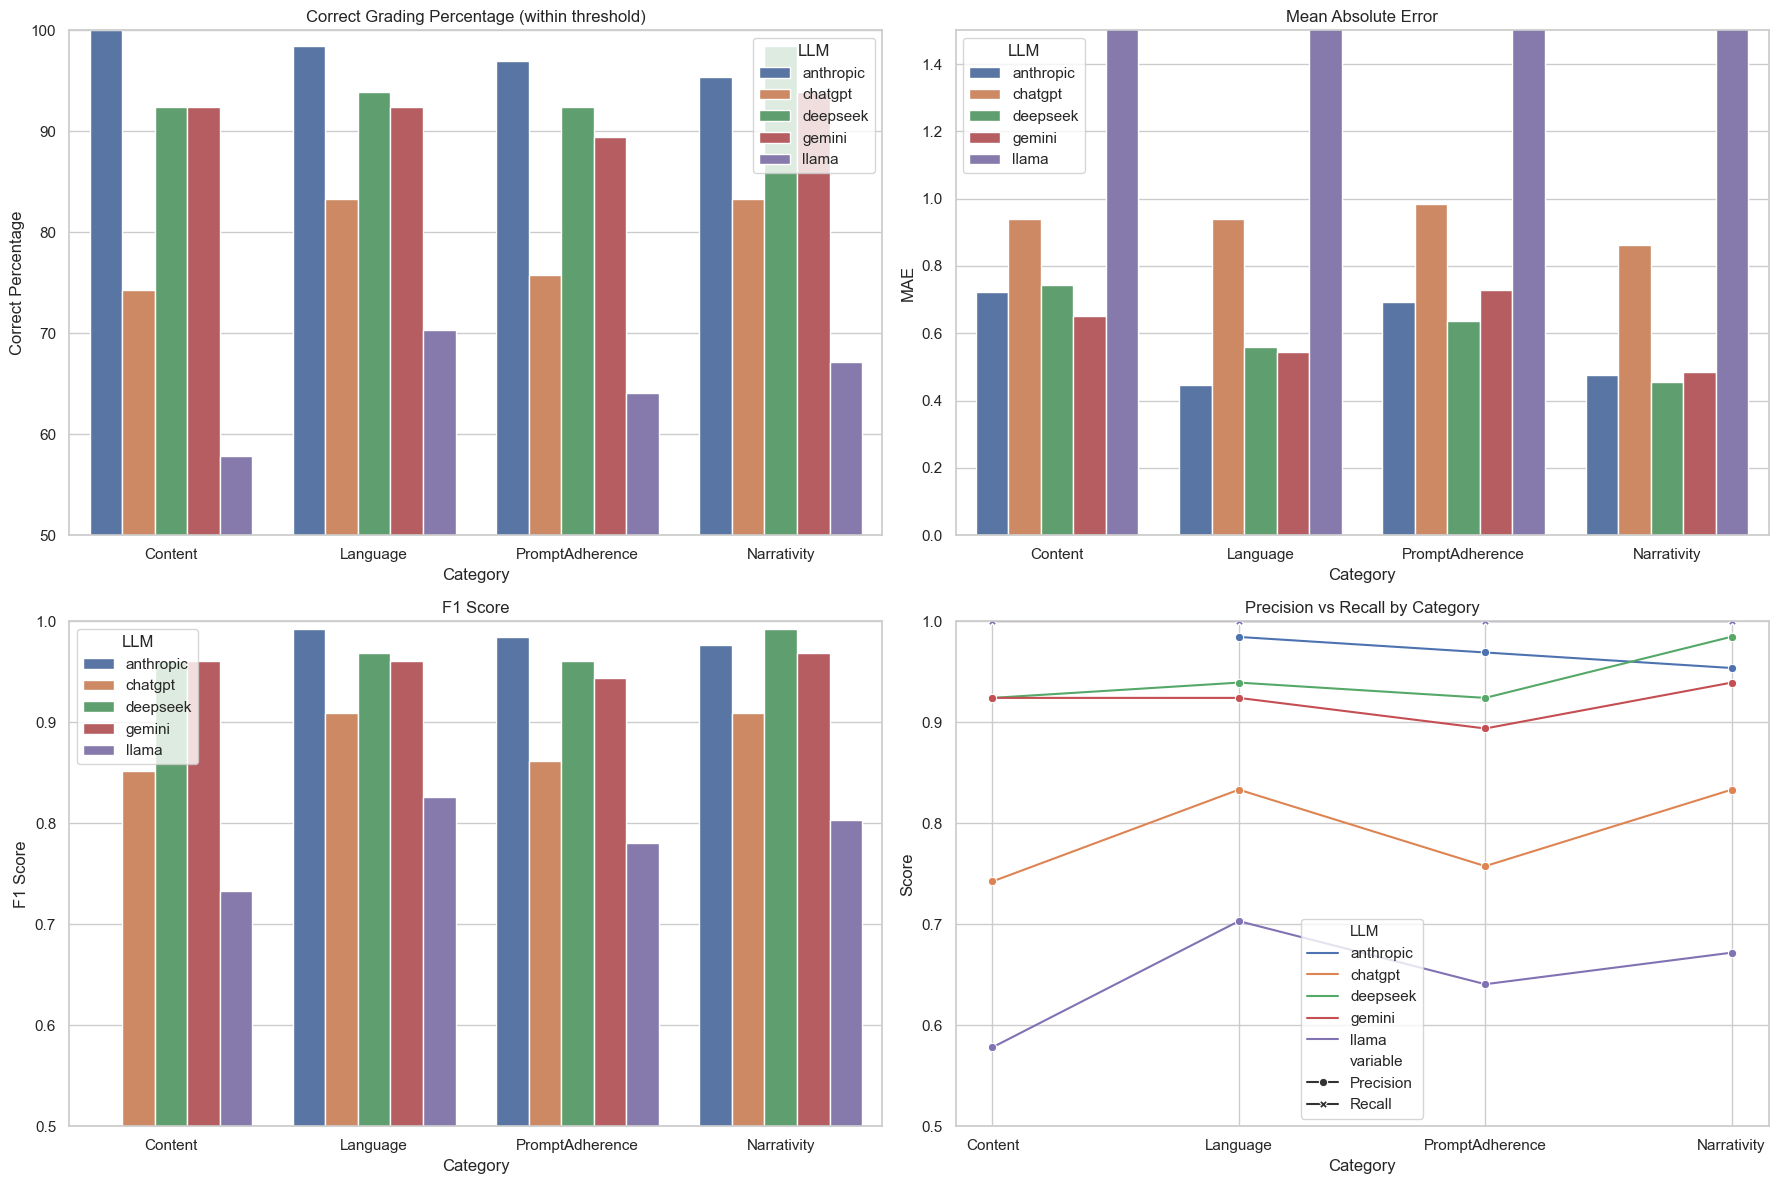

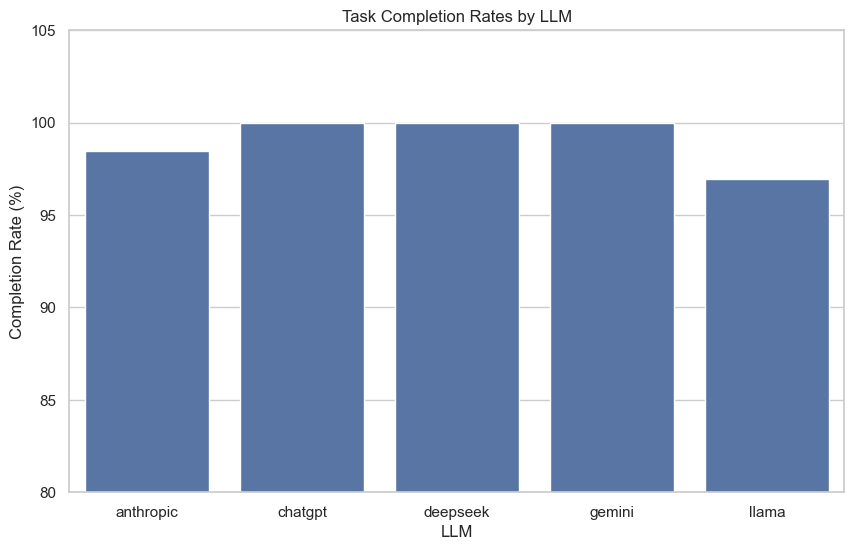

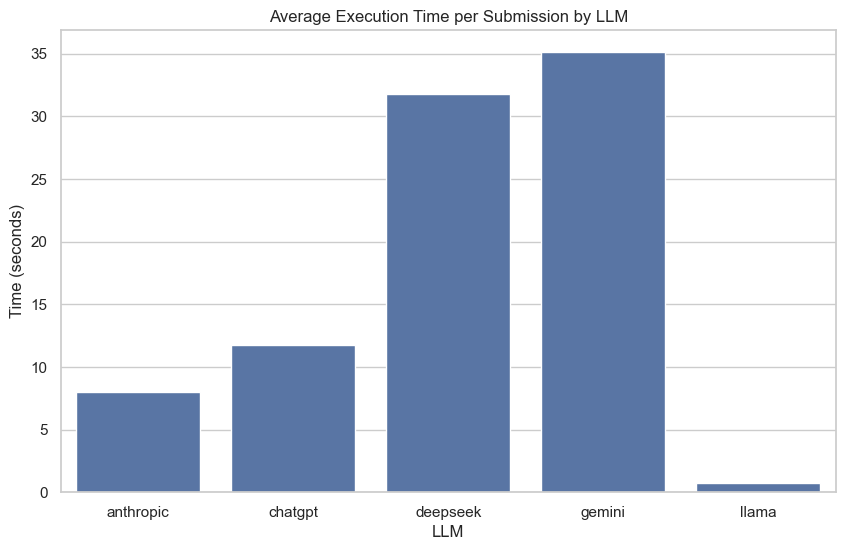


--- Actionable Suggestion Analysis ---
{
    "anthropic": {
        "non_actionable": 0.867579908675799,
        "vaguely_actionable": 0.045662100456621,
        "specifically_actionable": 0.0867579908675799,
        "total_comments": 219
    },
    "chatgpt": {
        "non_actionable": 0.8452380952380952,
        "vaguely_actionable": 0.15476190476190477,
        "specifically_actionable": 0.0,
        "total_comments": 84
    },
    "deepseek": {
        "non_actionable": 0.9920634920634921,
        "vaguely_actionable": 0.007936507936507936,
        "specifically_actionable": 0.0,
        "total_comments": 252
    },
    "gemini": {
        "non_actionable": 0.924187725631769,
        "vaguely_actionable": 0.021660649819494584,
        "specifically_actionable": 0.05415162454873646,
        "total_comments": 277
    },
    "llama": {
        "non_actionable": 0.8201438848920863,
        "vaguely_actionable": 0.04316546762589928,
        "specifically_actionable": 0.136690647482014

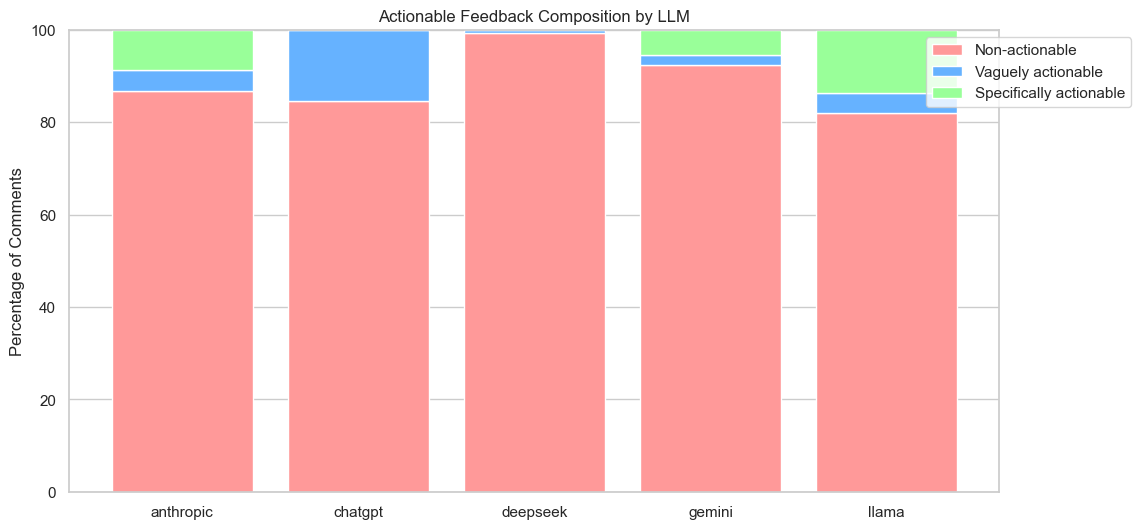

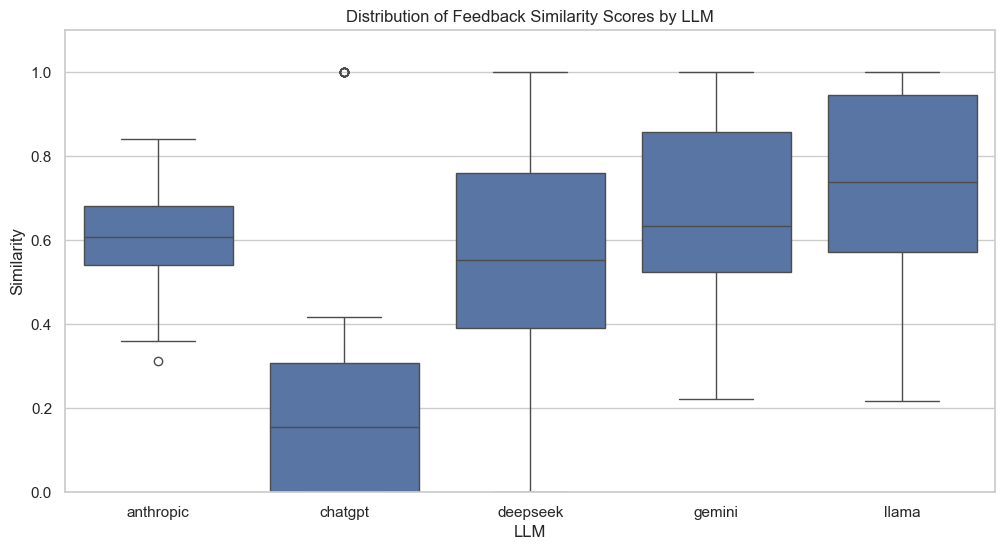

In [ ]:
print("\n--- ESSAY CATEGORY 2 ---")

llm_data = results2.to_dict(orient='records')
human_data = human_graded_scores2.to_dict(orient='records')
categories = grading_category2
category_maxima = rubric_maxima2
category_range = expected_grade_range2
print("\n--- CONSISTENCY ---")
consistency = calculate_consistency(llm_data, categories)
print(consistency)
print("\n--- ACCURAYCY 1 ---")
accuracy1 = calculate_accuracy(llm_data, human_data, categories)
print(accuracy1)
print("\n--- ACCURAYCY 2 ---")
accuracy2 = evaluate_llm_grading_performance(llm_data, human_data, categories, threshold)
print(accuracy2)
print("\n--- TASK COMPLETION RATE---")
task_completion = calculate_task_completion_rate(llm_data, no_of_graded_work)
print(task_completion)
print("\n--- AVERAGE EXECUTION TIME ---")
execution_time = calculate_execution_time(llm_data)
print(execution_time)
inflation_deflation_results = check_grade_inflation_deflation(llm_data, category_maxima, category_range)
print("\n--- Grade Inflation/Deflation Check ---")
print(json.dumps(inflation_deflation_results, indent=4))

visualize_consistency(consistency)
visualize_accuracy(accuracy1)
visualize_classification_metrics(accuracy2)
visualize_completion_rates(task_completion)
visualize_execution_times(execution_time)
visualize_comparison_radar(consistency, accuracy1, execution_time)
visualize_inflation_deflation(inflation_deflation_results)
# View all visualizations together in a dashboard
visualize_all_results(consistency, accuracy1, accuracy2, 
                     task_completion, execution_time, inflation_deflation_results)

#analysis of feedback quality


actionable_suggestions_results = analyze_actionable_suggestions(llm_data)
print("\n--- Actionable Suggestion Analysis ---")
print(json.dumps(actionable_suggestions_results, indent=4))

feedback_similarity_results = calculate_feedback_similarity(llm_data)
print("\n--- Feedback Similarity Between LLMs ---")
print(json.dumps(feedback_similarity_results, indent=4))

visualize_actionable_suggestions(actionable_suggestions_results)
visualize_feedback_similarity(feedback_similarity_results)


--- ESSAY CATEGORY 3 ---

--- CONSISTENCY ---
{'anthropic': {'average_std_dev_Content': np.float64(0.3428396514843866), 'icc_Content': np.float64(0.7251908396946561), 'average_std_dev_Language': np.float64(0.19284730395996752), 'icc_Language': np.float64(0.7519083969465649), 'average_std_dev_PromptAdherence': np.float64(0.23570226039551584), 'icc_PromptAdherence': np.float64(0.7987697715289978), 'average_std_dev_Narrativity': np.float64(0.27855721683106416), 'icc_Narrativity': np.float64(0.7495309568480302)}, 'chatgpt': {'average_std_dev_Content': np.float64(0.36426712970216074), 'icc_Content': np.float64(0.6608505997818978), 'average_std_dev_Language': np.float64(0.3214121732666124), 'icc_Language': np.float64(0.565157750342936), 'average_std_dev_PromptAdherence': np.float64(0.3214121732666124), 'icc_PromptAdherence': np.float64(0.7172011661807579), 'average_std_dev_Narrativity': np.float64(0.36426712970216074), 'icc_Narrativity': np.float64(0.6201975850713498)}, 'deepseek': {'averag

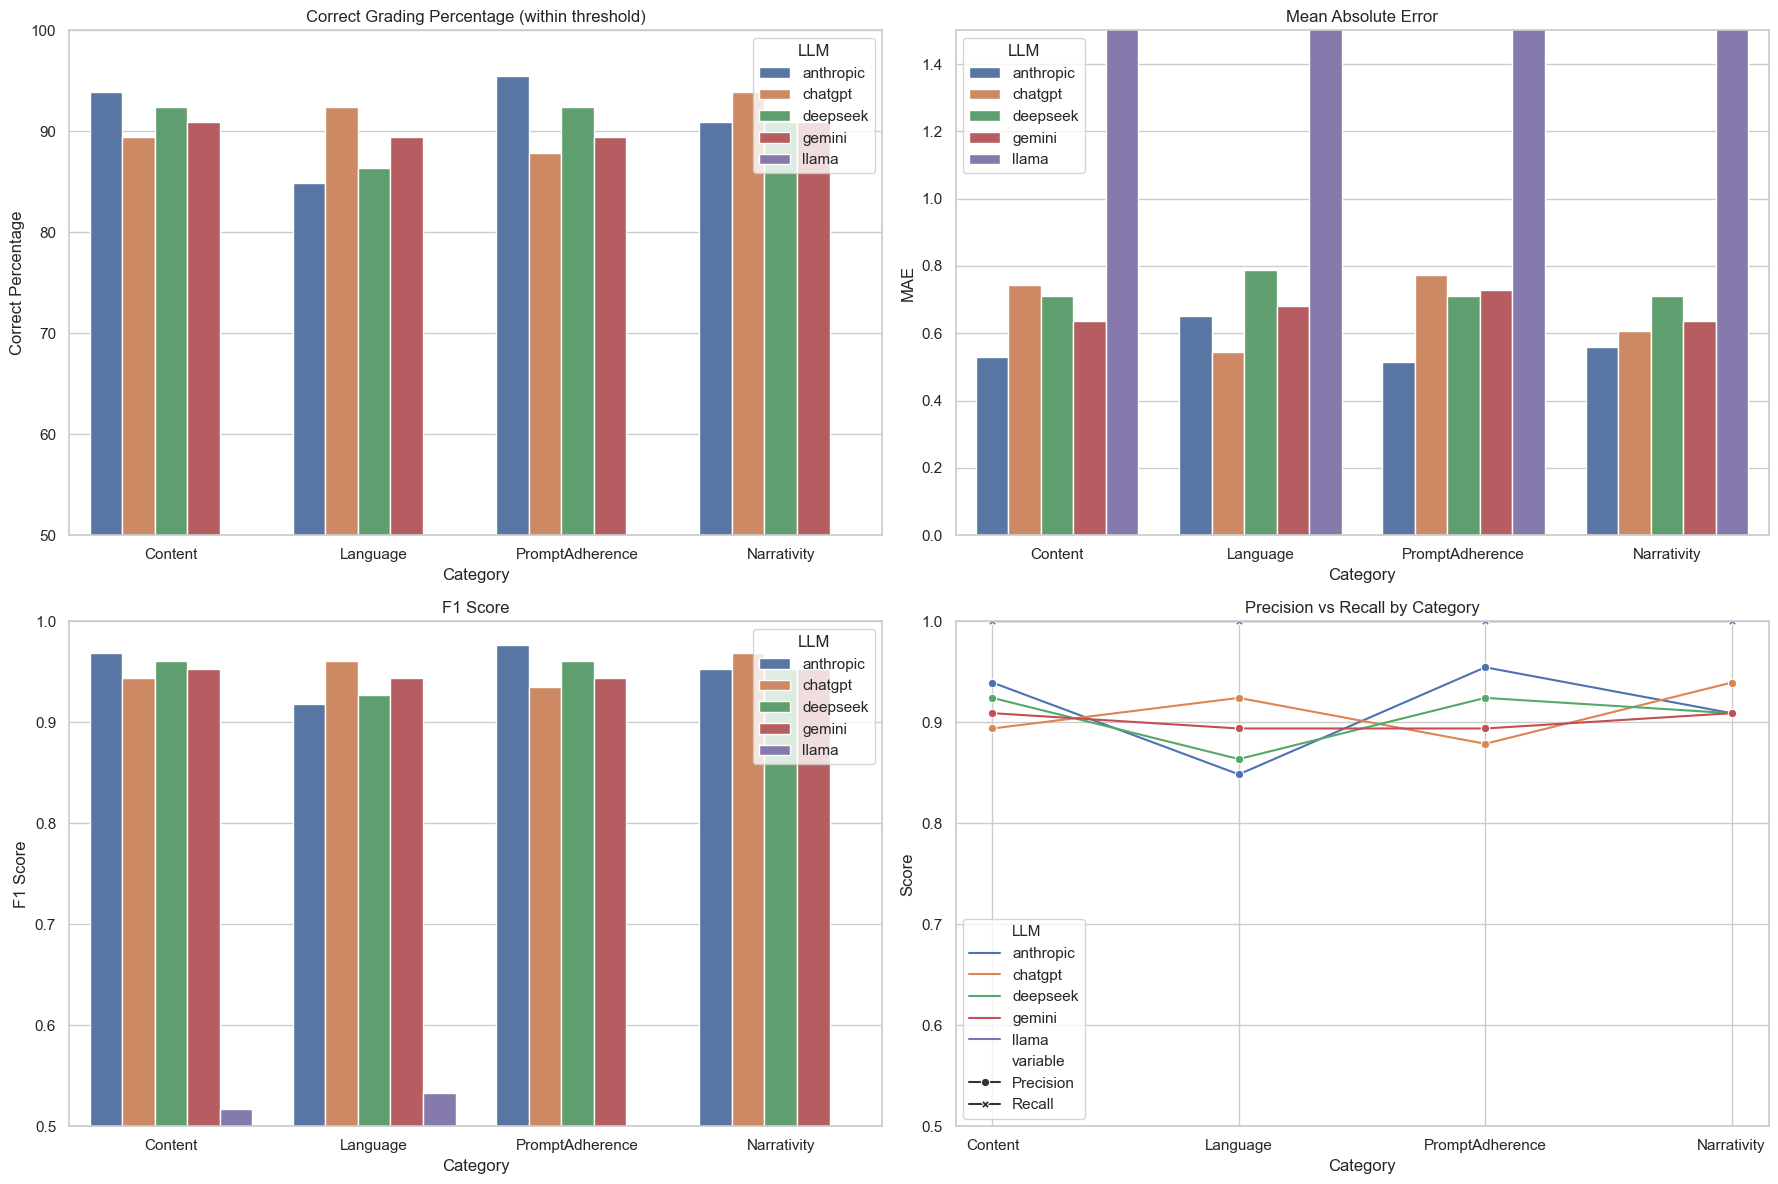

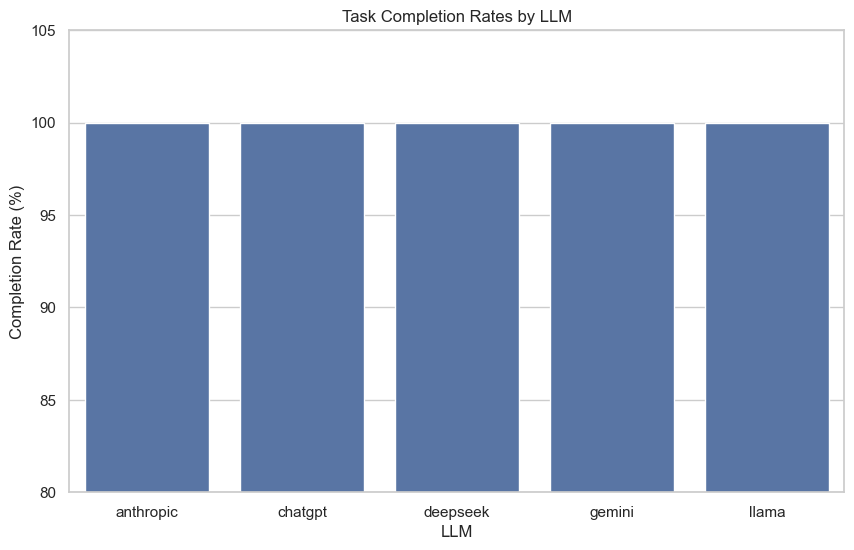

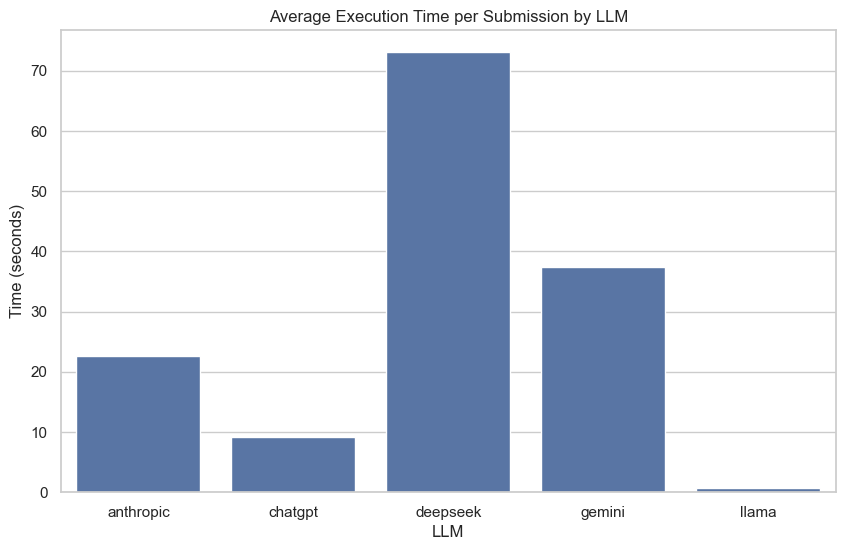


--- Actionable Suggestion Analysis ---
{
    "anthropic": {
        "non_actionable": 0.8357487922705314,
        "vaguely_actionable": 0.05314009661835749,
        "specifically_actionable": 0.1111111111111111,
        "total_comments": 207
    },
    "chatgpt": {
        "non_actionable": 0.9393939393939394,
        "vaguely_actionable": 0.030303030303030304,
        "specifically_actionable": 0.030303030303030304,
        "total_comments": 66
    },
    "deepseek": {
        "non_actionable": 0.9716981132075472,
        "vaguely_actionable": 0.0047169811320754715,
        "specifically_actionable": 0.02358490566037736,
        "total_comments": 212
    },
    "gemini": {
        "non_actionable": 0.9096509240246407,
        "vaguely_actionable": 0.018480492813141684,
        "specifically_actionable": 0.07186858316221766,
        "total_comments": 487
    },
    "llama": {
        "non_actionable": 0.8071428571428572,
        "vaguely_actionable": 0.12142857142857143,
        "spec

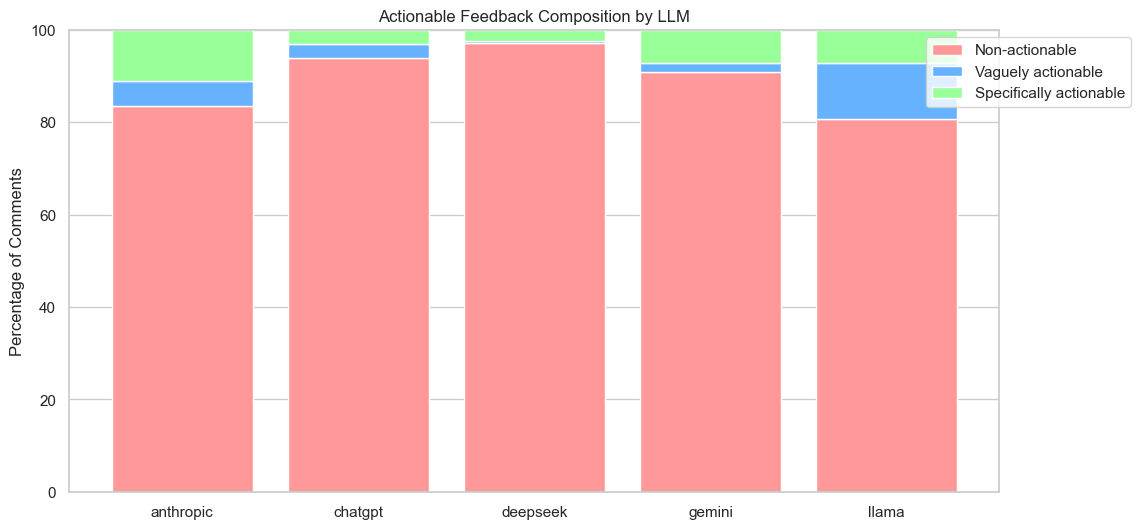

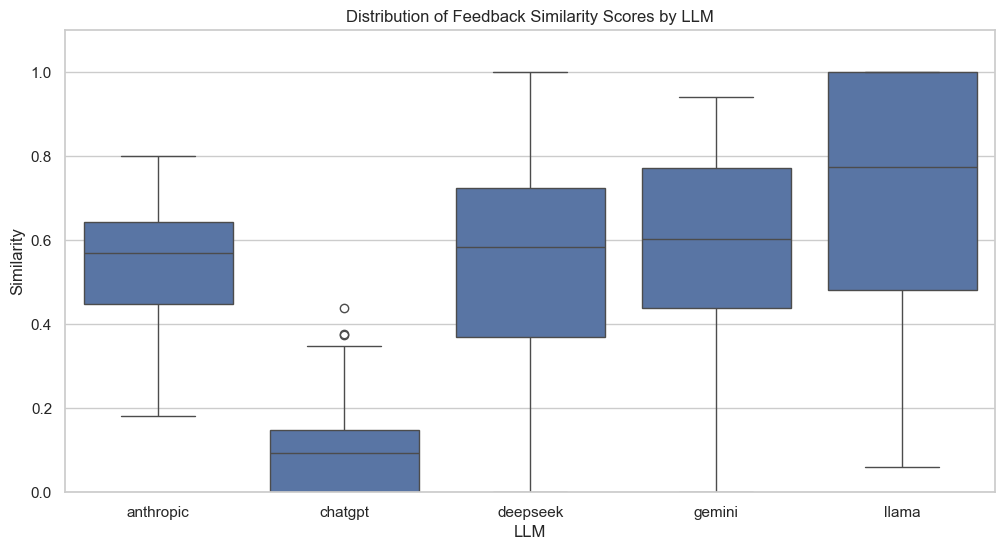

In [ ]:
print("\n--- ESSAY CATEGORY 3 ---")


llm_data = results3.to_dict(orient='records')
human_data = human_graded_scores3.to_dict(orient='records')
categories = grading_category3
category_maxima = rubric_maxima3
category_range = expected_grade_range3
print("\n--- CONSISTENCY ---")
consistency = calculate_consistency(llm_data, categories)
print(consistency)
print("\n--- ACCURAYCY 1 ---")
accuracy1 = calculate_accuracy(llm_data, human_data, categories)
print(accuracy1)
print("\n--- ACCURAYCY 2 ---")
accuracy2 = evaluate_llm_grading_performance(llm_data, human_data, categories, threshold)
print(accuracy2)
print("\n--- TASK COMPLETION RATE---")
task_completion = calculate_task_completion_rate(llm_data, no_of_graded_work)
print(task_completion)
print("\n--- AVERAGE EXECUTION TIME ---")
execution_time = calculate_execution_time(llm_data)
print(execution_time)
inflation_deflation_results = check_grade_inflation_deflation(llm_data, category_maxima, category_range)
print("\n--- Grade Inflation/Deflation Check ---")
print(json.dumps(inflation_deflation_results, indent=4))

visualize_consistency(consistency)
visualize_accuracy(accuracy1)
visualize_classification_metrics(accuracy2)
visualize_completion_rates(task_completion)
visualize_execution_times(execution_time)
visualize_comparison_radar(consistency, accuracy1, execution_time)
visualize_inflation_deflation(inflation_deflation_results)
# View all visualizations together in a dashboard
visualize_all_results(consistency, accuracy1, accuracy2, 
                     task_completion, execution_time, inflation_deflation_results)

#analysis of feedback quality


actionable_suggestions_results = analyze_actionable_suggestions(llm_data)
print("\n--- Actionable Suggestion Analysis ---")
print(json.dumps(actionable_suggestions_results, indent=4))

feedback_similarity_results = calculate_feedback_similarity(llm_data)
print("\n--- Feedback Similarity Between LLMs ---")
print(json.dumps(feedback_similarity_results, indent=4))

visualize_actionable_suggestions(actionable_suggestions_results)
visualize_feedback_similarity(feedback_similarity_results)